I'm using LSTM instead RNN coz RNN has a big problem of vanishing and exploding gradients, hence RNN can’t hold longer sequential information and in the Text-generation task, we particularly need a model that can memorize a long sequence of data. for this purpose LSTM came into the picture.

Source of dataset on Kaggle: https://www.kaggle.com/datasets/freecodecamp/all-posts-public-main-chatroom/download?datasetVersionNumber=2

# Import required libraries

In [57]:
# keras module for building LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint
import random
import sys
import io



# set seeds for reproducability
import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
import numpy as np
import string, os

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
# Download helper function
!wget https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py


--2023-09-25 22:25:15--  https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py.1’

helper_function.py. 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-25 22:25:15 (64.7 MB/s) - ‘helper_function.py.1’ saved [10246/10246]



In [33]:
# Import series of helper functions for the notebook
from helper_function import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [39]:
# Download dataset
!wget https://raw.githubusercontent.com/SNNJM/TF_DL_SkillsChecklist/main/4_NLP/dataset/freecodecamp_casual_chatroom_anon.csv

--2023-09-25 22:33:34--  https://raw.githubusercontent.com/SNNJM/TF_DL_SkillsChecklist/main/4_NLP/dataset/freecodecamp_casual_chatroom_anon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19476181 (19M) [text/plain]
Saving to: ‘freecodecamp_casual_chatroom_anon.csv’

freecodecamp_casual 100%[===================>]  18.57M  --.-KB/s    in 0.1s    

2023-09-25 22:33:35 (153 MB/s) - ‘freecodecamp_casual_chatroom_anon.csv’ saved [19476181/19476181]



In [41]:
#Read data
import pandas as pd
import numpy as np


file = '/content/freecodecamp_casual_chatroom_anon.csv'

In [42]:
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

In [47]:
chat = pd.read_csv(file,encoding='ISO-8859-1', usecols = ['fromUser.id', 'text'])
# We don't want bots :)
chat = chat[chat['fromUser.id'] != '55b977f00fc9f982beab7883']
chat.head()

,fromUser.id,text
0,546fd99cdb8155e6700d6ec8,no legumes either
1,54a47e0cdb8155e6700e486e,That bullet proof coffee sounds insane.
2,54a47e0cdb8155e6700e486e,That guy has huge eyes.
3,546fd99cdb8155e6700d6ec8,@54a47e0cdb8155e6700e486e It is. but it works....
4,54a44bbbdb8155e6700e47de,They guy that came up with the idea is kind of...


##Visualize data

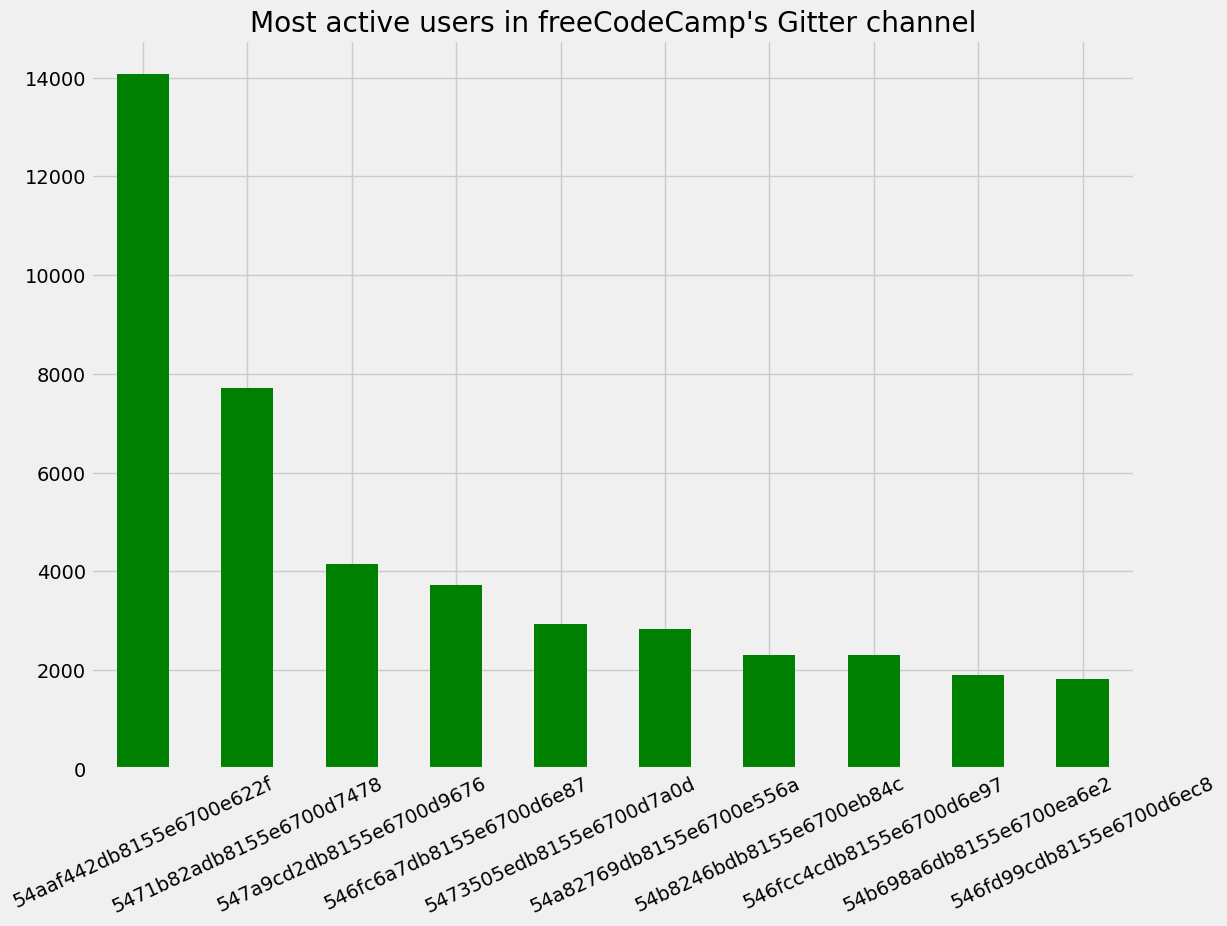

In [48]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

f, g = plt.subplots(figsize=(12, 9))
chat['fromUser.id'].value_counts().head(10).plot.bar(color="green")
g.set_xticklabels(g.get_xticklabels(), rotation=25)
plt.title("Most active users in freeCodeCamp's Gitter channel")
plt.show(g)

In [49]:
#check most freq user


chat[chat['fromUser.id'] == "54aaf442db8155e6700e622f"].text.head(20)



5618    Hello everyone, I'm new to the FreeCodeCamp co...
5621    It is so much easier to learn code on your own...
5623                                        :sparkles: :)
5625                                               Hello!
5629                  Anyone else here from the Bay Area?
5633    Not quite the response I expected to generate....
5635    Well, as we are kinda the seat of the tech ind...
5636                                                 ;)\n
5648    I was born and raised here. Started coding web...
5649     @549998fcdb8155e6700e264b The Bay Area is a g...
5650    @54aaf531db8155e6700e6238 Have fun on your jou...
5651    @546fcc4cdb8155e6700d6e97  How long have you b...
5663    Well. I have only written HTML & CSS myself. I...
5664                           @549998fcdb8155e6700e264b 
5665    @546fcc4cdb8155e6700d6e97  Cool. I like the ap...
5670    That's cool. I started with Codecademy a few w...
5672                                              Sweet. 
5674    I thin

# Pre-processing data

Right now we have a dataframe with columns corresponding to user ids and message text where each row corresponds to a single message sent.

This is pretty far from the 3D shape the input layer of our LSTM network requires: model.add(LSTM(batch_size, input_shape=(time_steps, features))) where batch_size is the number of sequences in each sample (can be one or more), time_steps is the size of observations in each sample, and features is the number of possible observable features (i.e., characters in our case).

So how do we get from a dataframe to sequence data in the correct shape? I'll break it into three steps:

1. Subset the data to form a corpus
2. Format the corpus from #1 into arrays of semi-overlapping sequences of uniform length and next characters
3. Represent the sequence data from #2 as sparse boolean tensors


### Subset data to form corpus

In [50]:
user = chat[chat['fromUser.id'] == '54aaf442db8155e6700e622f'].text

n_messages = len(user)
n_chars = len(' '.join(map(str, user)))

print("54aaf442db8155e6700e622f accounts for %d messages" % n_messages)
print("Their messages add up to %d characters" % n_chars)

54aaf442db8155e6700e622f accounts for 14065 messages
Their messages add up to 671667 characters


In [52]:
sample_size = int(len(user) * 0.2)

user = user[:sample_size]
user = ' '.join(map(str, user)).lower()

user[:100] # Show first 100 characters


"hello everyone, i'm new to the freecodecamp community as of about 5 mins ago! :) it is so much easie"

### Format the corpus into arrays of semi-overlapping sequences of uniform length and next characters

In [53]:
chars = sorted(list(set(user)))
print('Count of unique characters (i.e., features):', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))



Count of unique characters (i.e., features): 69


In [54]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(user) - maxlen, step):
    sentences.append(user[i: i + maxlen])
    next_chars.append(user[i + maxlen])
print('Number of sequences:', len(sentences), "\n")

print(sentences[:10], "\n")
print(next_chars[:10])

Number of sequences: 46683 

["hello everyone, i'm new to the freecodec", "lo everyone, i'm new to the freecodecamp", "everyone, i'm new to the freecodecamp co", "ryone, i'm new to the freecodecamp commu", "ne, i'm new to the freecodecamp communit", " i'm new to the freecodecamp community a", 'm new to the freecodecamp community as o', 'ew to the freecodecamp community as of a', 'to the freecodecamp community as of abou', 'the freecodecamp community as of about 5'] 

['a', ' ', 'm', 'n', 'y', 's', 'f', 'b', 't', ' ']


### Represent the sequence data as sparse boolean tensors

In [55]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# Model Creation

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))



optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)





In [61]:
model.save("model.h5")

In [62]:
# define the checkpoint
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

# fit model using our gpu
with tf.device('/gpu:0'):
    model.fit(x, y,
              batch_size=128,
              epochs=15,
              verbose=2,
              callbacks=[generate_text, checkpoint])

Epoch 1/15

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "a function to determine if there is a cu"
a function to determine if there is a cuan a a i a ae t i at a o oo  i a t an i a ao  in  on t a in a i to a to oo a oo e a t in ta o i i i i ie  on o an an a  ao in a i i i i at te aan a a in t ao o a at o i to te e a ao in y  ao s an in to an  io i eo i in at o t in i e o i to to i a a in  aa l in i to i t to ia o in o o o o i t in an  io a o o at i in o to ie to oa y o an e at a an i in ha  i a on a o a a in i i thi  ao  oe an e to o
----- diversity: 0.5
----- Generating with seed: "a function to determine if there is a cu"
a function to determine if there is a cu go one tuoto ins if ati t anlre t atafs mp is tit cho o n in i a wor ta lerun  oor r in it ta e af tage toa iee tal soi inaide it in  oi mi g a at itie inu  and t e too an s aot .  oo nern i  on. y fo ton irod is anonie e an an ore o ton s. i  ot aee  oon i oie  e te to e i i ne aes a